# 正則化を、重みの可視化で理解する

データはMNISTを使用。
* 1 普通に学習
* 2 正則化の働きを見たいので、過学習するようなデータを準備
* 3-1 正則化なし
* 3-2　L2正則化
* 3-3　L1正則化

In [27]:
# Kerasで必要なものをimport
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(111)

## 1. まずは普通に学習してみる


In [28]:
# データを用意＆加工
size_img = 28
n_label = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 1, size_img, size_img).astype('float32') / 255.
X_test = X_test.reshape(-1, 1, size_img, size_img).astype('float32') / 255.
Y_train = np_utils.to_categorical(y_train, n_label)
Y_test = np_utils.to_categorical(y_test, n_label)

# flatten the input images
shape_org = X_train.shape
X_train = X_train.reshape(-1, size_img * size_img)
X_test = X_test.reshape(-1, size_img * size_img)
print('transform X_train shape: %s -> %s' % (shape_org, X_train.shape))

transform X_train shape: (60000, 1, 28, 28) -> (60000, 784)


In [29]:
# モデル構築
# MNIST dataだが、CNNを使わずMLPでモデルを構築する
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(n_label))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
weights0 = model.get_weights()

In [30]:
# まず普通にMLPを学習
# EarlyStoppingは、validation dataが改善されなくなった時点で学習を打ち切る。
model.fit(X_train, Y_train, batch_size=30, nb_epoch=10,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss')])

# テストデータで評価
v = model.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 12s - loss: 0.2577 - acc: 0.9235 - val_loss: 0.1074 - val_acc: 0.9682
Epoch 2/10
54000/54000 [==============================] - 12s - loss: 0.1089 - acc: 0.9666 - val_loss: 0.0903 - val_acc: 0.9722
Epoch 3/10
54000/54000 [==============================] - 12s - loss: 0.0777 - acc: 0.9756 - val_loss: 0.0760 - val_acc: 0.9773
Epoch 4/10
 9952/10000 [============================>.] - ETA: 0s
Test accuracy 0.976


## 2. 過学習用のデータを作成

普通に学習させると~97%の精度。
今回は正則化のテストをしたいので、できるだけ過学習が起きやすいデータが欲しい。
そこで、
1. データ量を減らす (54000 -> 1000; 各数字100枚ずつ)
2. 歪みの大きいインプットイメージを選択的に使う

2を行うために、予測値が小さいものを選択する。
予測値は予測確度のようなものなので、この値が低いということはインプットの数字の形が歪で予測しづらいと期待される。

In [31]:
from collections import defaultdict
import pickle

n_each = 100  # 各数字100枚ずつ
pred = model.predict(X_train)

dic = defaultdict(list)
for i, (t, p) in enumerate(zip(pred.argmax(axis=1), pred.max(axis=1))):
    dic[t].append((p, i))

indices = []
for t, pi in dic.items():
    # 小さい順にn_each枚ずつ（のindex)を取得
    indices += [i for _, i in sorted(dic[t])[:n_each]]

X_train2 = X_train[indices]
Y_train2 = Y_train[indices]
print(X_train2.shape)

with open('data.pkl', 'wb') as g:
    pickle.dump(X_train2, g)
    pickle.dump(Y_train2, g)
    pickle.dump(X_test, g)
    pickle.dump(Y_test, g)

(1000, 784)


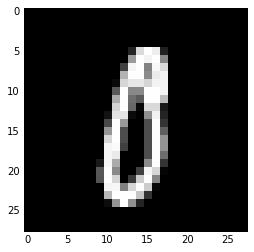

In [32]:
# 過学習用のデータの例
plt.imshow(X_train2[77].reshape(size_img, size_img), interpolation='nearest', cmap='gray')

## 3. 重みの可視化

上記で作ったX_train2, Y_train2で
* 3-1 正則化なし 
* 3-2 L2正則化
* 3-3 L1正則化  

で学習した場合を比較する。


## 3-1 正則化なし

正則化を理解するためには、まず基準として正則化なしの場合を調査する。

In [33]:
# 正則化なしのフィット
model.set_weights(weights0)
model.fit(X_train2, Y_train2, batch_size=30, nb_epoch=20)

# Test dataの精度
print()
v = model.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

Epoch 1/20
1000/1000 [==============================] - 0s - loss: 2.0961 - acc: 0.2320     
Epoch 2/20
1000/1000 [==============================] - 0s - loss: 1.5509 - acc: 0.4710     
Epoch 3/20
1000/1000 [==============================] - 0s - loss: 1.2580 - acc: 0.5570     
Epoch 4/20
1000/1000 [==============================] - 0s - loss: 1.0150 - acc: 0.6570     
Epoch 5/20
1000/1000 [==============================] - 0s - loss: 0.8592 - acc: 0.7250     
Epoch 6/20
1000/1000 [==============================] - 0s - loss: 0.7169 - acc: 0.7800     
Epoch 7/20
1000/1000 [==============================] - 0s - loss: 0.5905 - acc: 0.8240     
Epoch 8/20
1000/1000 [==============================] - 0s - loss: 0.5051 - acc: 0.8490     
Epoch 9/20
1000/1000 [==============================] - 0s - loss: 0.3940 - acc: 0.8890     
Epoch 10/20
1000/1000 [==============================] - 0s - loss: 0.3281 - acc: 0.9170     
Epoch 11/20
1000/1000 [==============================] - 0s - loss: 0

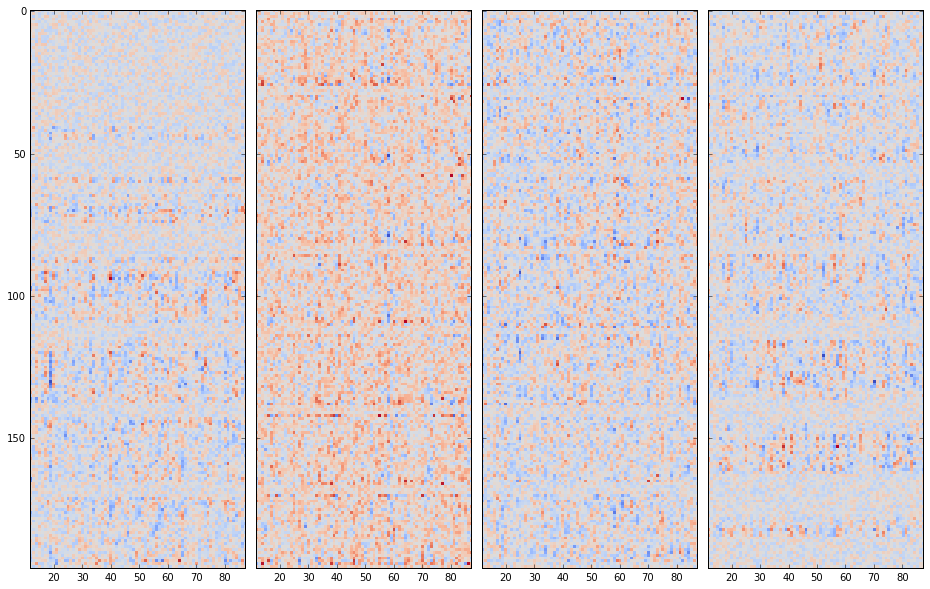

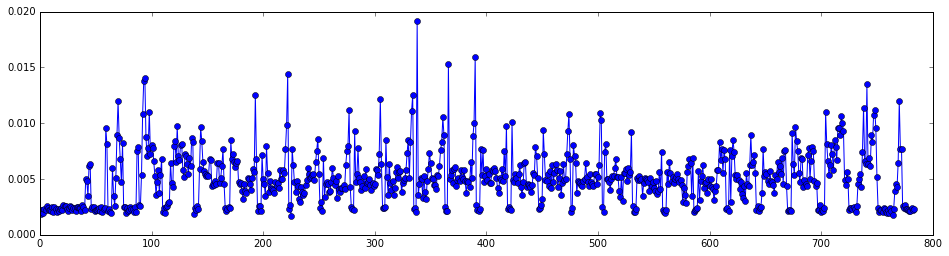

In [34]:
w1 = model.layers[0].get_weights()[0]  # 1層目の重み

# 重みのイメージ
fig, axes = plt.subplots(1, 4, figsize=(16, 10), sharey=True)
fig.subplots_adjust(wspace=0.05)
for i in range(4):
    axes[i].imshow(w1[28*7*i:28*7*(i+1)], cmap='coolwarm', interpolation='nearest')
    
# 重みの、各input unitごとの2乗和の平均値
plt.figure(figsize=(16, 4))
plt.plot((w1**2).mean(axis=1), 'o-')

### 考察

過学習しているのがわかる。つまり正解率はTraining dataでは~97%だが、テストデータでは50-60%と低くなっている。

図はviz_mlp_check.ipynbの図と基本的に同じ（もし見てなければ、そのnoteを見た方が、この後も分かりやすいと思う）。
念のためもう一度説明すると、1層目の重みを可視化したものが、上記2つの図
- 上のパネルは、縦軸がinput (dim_in=784 units), 横軸がそれぞれのunitから次の層（100 units）へのそれぞれの重みの大きさ。絶対値が大きいほど色が濃くなる。ただし、dim_in=784次元と長いので4分割（196次元ごと）に分けて、横に並べている。従って、上パネルの一番左が0-195番目のunit,　隣が196-391番目のunit...となっている。
- 下のパネルは、行方向（input層）に平均をとったもの（= 各input　unitの次の層への重みの平均）。横軸がinput unitの各番号で、縦軸が平均値。

viz_mlp_check.ipynbとのときのチェックデータと異なり、インプットデータの中に明らかな正解データがあるわけではないので、全体的に多くのunitで重みが存在する。とりあえず、正則化なしの場合のこの状態をデフォルトとして、次に正則化の場合を調査する。

# 2. L2正則化

In [35]:
# モデルの構築; 第1層にl2正則化を入れいている
# 後は変更なし
v2 = 0.03
model2 = Sequential()
model2.add(Dense(100, input_dim=X_train2.shape[1], W_regularizer=l2(v2)))
model2.add(Activation('relu'))
model2.add(Dense(100))
model2.add(Activation('relu'))
model2.add(Dense(n_label))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
weights2 = model2.get_weights()

In [36]:
model2.set_weights(weights2)
model2.fit(X_train2, Y_train2, batch_size=30, nb_epoch=20)

Epoch 1/20
1000/1000 [==============================] - 0s - loss: 5.6042 - acc: 0.2600     
Epoch 2/20
1000/1000 [==============================] - 0s - loss: 3.0654 - acc: 0.4140     
Epoch 3/20
1000/1000 [==============================] - 0s - loss: 2.2051 - acc: 0.4820     
Epoch 4/20
1000/1000 [==============================] - 0s - loss: 1.8728 - acc: 0.5240     
Epoch 5/20
1000/1000 [==============================] - 0s - loss: 1.6969 - acc: 0.5510     
Epoch 6/20
1000/1000 [==============================] - 0s - loss: 1.5741 - acc: 0.5940     
Epoch 7/20
1000/1000 [==============================] - 0s - loss: 1.4799 - acc: 0.6100     
Epoch 8/20
1000/1000 [==============================] - 0s - loss: 1.4547 - acc: 0.6020     
Epoch 9/20
1000/1000 [==============================] - 0s - loss: 1.3794 - acc: 0.6250     
Epoch 10/20
1000/1000 [==============================] - 0s - loss: 1.3336 - acc: 0.6640     
Epoch 11/20
1000/1000 [==============================] - 0s - loss: 1

 9920/10000 [============================>.] - ETA: 0s
Test accuracy 0.634


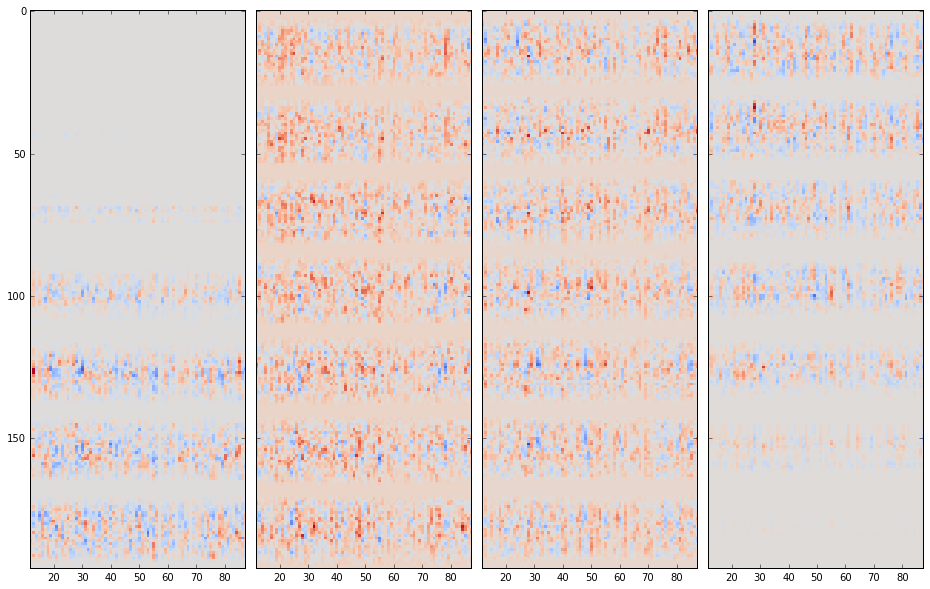

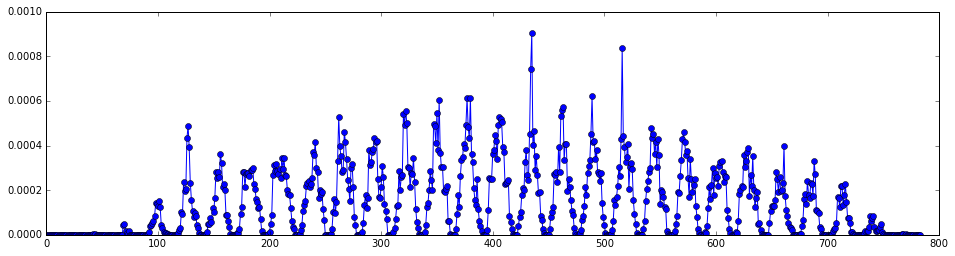

In [37]:
# Test dataの精度
v = model2.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

w1 = model2.layers[0].get_weights()[0]  # 1層目の重み

# 重みのイメージ
fig, axes = plt.subplots(1, 4, figsize=(16, 10), sharey=True)
fig.subplots_adjust(wspace=0.05)
for i in range(4):
    axes[i].imshow(w1[28*7*i:28*7*(i+1)], cmap='coolwarm', interpolation='nearest')
    
# 重みの、各input unitごとの2乗和の平均値
plt.figure(figsize=(16, 4))
plt.plot((w1**2).mean(axis=1), 'o-')

### 考察

正則化なしと比べると、重みのガタツキがなくなり、重みが周期的に増減するのがクリアに見える。
重みが高い場所は、数字が主に存在する中心付近のピクセルに対応すると考えられる（2次元のピクセルを1次元にフラット化したため、中心付近のピクセルが周期的に現れる）。正則化なしでも一応あるのだろうが、大きい重みがあるなどしてL2正則化ほどクリアでない。

L2正則化によって重みの大きさがsuppressされたため、情報がほぼない周囲のピクセルの重みがほぼ0になった。
重みの絶対値の大きさも小さくなっている。少数サンプルにしか現れないパターンのような、あまり重要でないピクセル
の重みを小さくすることで、overfitを抑制していると考えられる。Training dataの正解率も正則化なしに比べ
低く、overfitが抑制されていることが確認できる。

正解率は、（このデータ・セットでは）正則化なしより良いが、正則化のデータセットの選び方によってはあまり改善されない場合がある。正則化を入れたからといって、必ずしも正解率が高くなるわけではない。ただし重みの分布が安定している分、正則化にした方が結果も安定すると期待できる。

l2を大きくすると下の例のように、より重要な重みだけに刈り取られているように見える。（おそらく使える重みが少なくなった分）正解率が低くなっている。

In [40]:
# l2の値を大きくする; 0.05 -> 1.0
v2 = 1.0
model2 = Sequential()
model2.add(Dense(100, input_dim=X_train2.shape[1], W_regularizer=l2(v2)))
model2.add(Activation('relu'))
model2.add(Dense(100))
model2.add(Activation('relu'))
model2.add(Dense(n_label))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
weights2 = model2.get_weights()

model2.set_weights(weights2)
model2.fit(X_train2, Y_train2, batch_size=30, nb_epoch=20)

Epoch 1/20
1000/1000 [==============================] - 0s - loss: 102.0684 - acc: 0.1540     
Epoch 2/20
1000/1000 [==============================] - 0s - loss: 22.4525 - acc: 0.2830     
Epoch 3/20
1000/1000 [==============================] - 0s - loss: 4.9625 - acc: 0.3470     
Epoch 4/20
1000/1000 [==============================] - 0s - loss: 2.3415 - acc: 0.3550     
Epoch 5/20
1000/1000 [==============================] - 0s - loss: 2.0368 - acc: 0.3690     
Epoch 6/20
1000/1000 [==============================] - 0s - loss: 2.0233 - acc: 0.3520     
Epoch 7/20
1000/1000 [==============================] - 0s - loss: 1.9798 - acc: 0.3890     
Epoch 8/20
1000/1000 [==============================] - 0s - loss: 1.9673 - acc: 0.3820     
Epoch 9/20
1000/1000 [==============================] - 0s - loss: 1.9755 - acc: 0.3740     
Epoch 10/20
1000/1000 [==============================] - 0s - loss: 1.9766 - acc: 0.4040     
Epoch 11/20
1000/1000 [==============================] - 0s - loss

 9888/10000 [============================>.] - ETA: 0s
Test accuracy 0.489


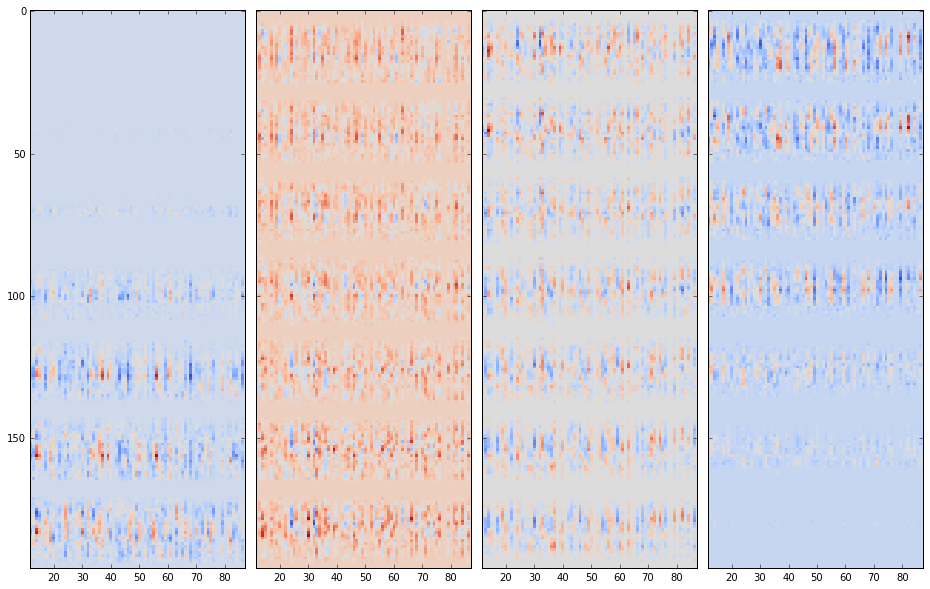

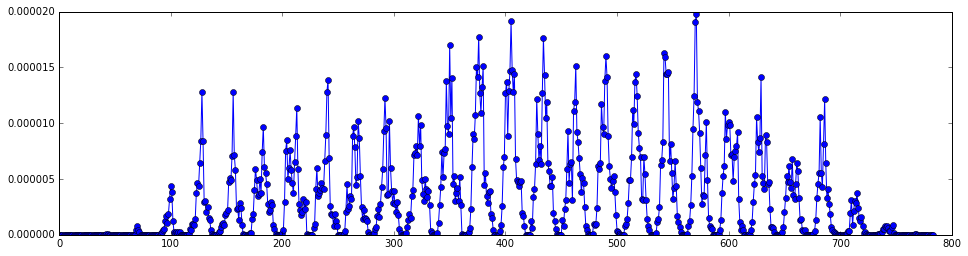

In [42]:
# Test dataの精度
v = model2.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

w1 = model2.layers[0].get_weights()[0]  # 1層目の重み

# 重みのイメージ
fig, axes = plt.subplots(1, 4, figsize=(16, 10), sharey=True)
fig.subplots_adjust(wspace=0.05)
for i in range(4):
    axes[i].imshow(w1[28*7*i:28*7*(i+1)], cmap='coolwarm', interpolation='nearest')
    
# 重みの、各input unitごとの2乗和の平均値
plt.figure(figsize=(16, 4))
plt.plot((w1**2).mean(axis=1), 'o-')

# L1正則化

L2からL1正則化に変更。その他の変更点はなし。

In [45]:
v1 = 0.005
model1 = Sequential()
model1.add(Dense(100, input_dim=X_train2.shape[1], W_regularizer=l1(v1)))
model1.add(Activation('relu'))
model1.add(Dense(100))
model1.add(Activation('relu'))
model1.add(Dense(n_label))
model1.add(Activation('softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
weights1 = model1.get_weights()

model1.set_weights(weights2)
model1.fit(X_train2, Y_train2, batch_size=30, nb_epoch=20)

Epoch 1/20
1000/1000 [==============================] - 0s - loss: 13.5628 - acc: 0.2150     
Epoch 2/20
1000/1000 [==============================] - 0s - loss: 6.1559 - acc: 0.3930     
Epoch 3/20
1000/1000 [==============================] - 0s - loss: 3.1499 - acc: 0.4310     
Epoch 4/20
1000/1000 [==============================] - 0s - loss: 2.4688 - acc: 0.4290     
Epoch 5/20
1000/1000 [==============================] - 0s - loss: 2.2306 - acc: 0.4670     
Epoch 6/20
1000/1000 [==============================] - 0s - loss: 2.1197 - acc: 0.4630     
Epoch 7/20
1000/1000 [==============================] - 0s - loss: 2.0666 - acc: 0.4550     
Epoch 8/20
1000/1000 [==============================] - 0s - loss: 2.0151 - acc: 0.4870     
Epoch 9/20
1000/1000 [==============================] - 0s - loss: 1.9619 - acc: 0.4990     
Epoch 10/20
1000/1000 [==============================] - 0s - loss: 1.9252 - acc: 0.5010     
Epoch 11/20
1000/1000 [==============================] - 0s - loss: 

 9824/10000 [============================>.] - ETA: 0s
Test accuracy 0.596


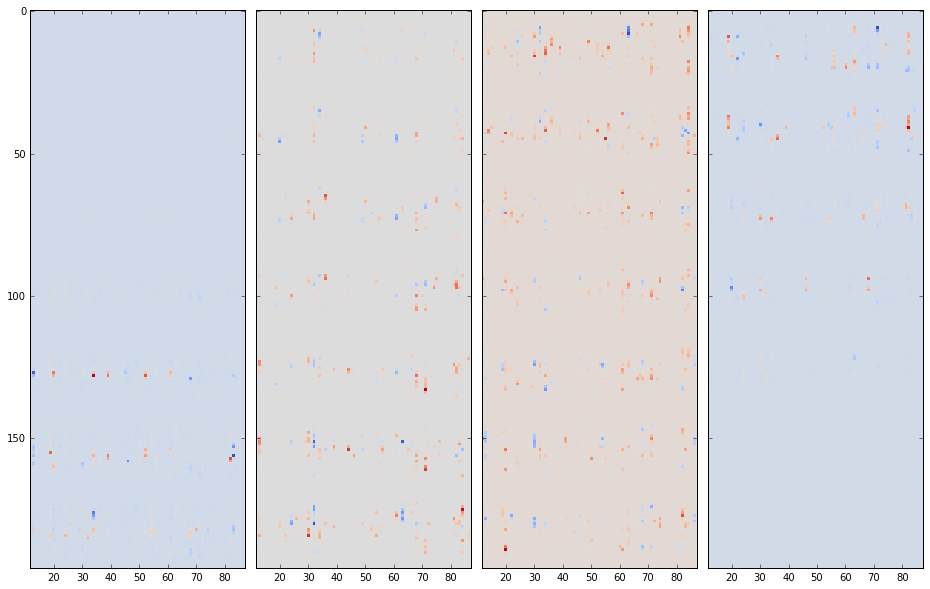

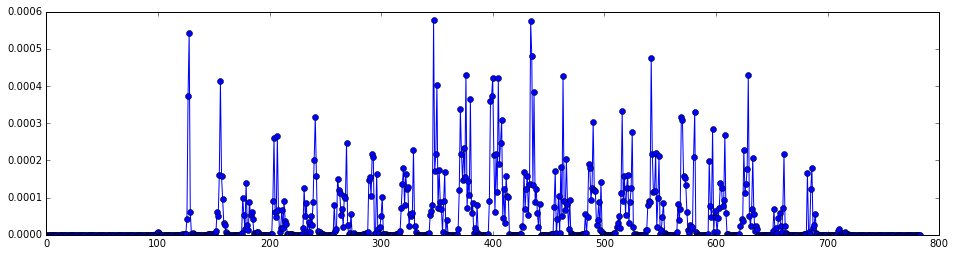

In [46]:
# Test dataの精度
v = model1.evaluate(X_test, Y_test)
print('\nTest accuracy %.3f' % v[1])

w1 = model1.layers[0].get_weights()[0]  # 1層目の重み

# 重みのイメージ
fig, axes = plt.subplots(1, 4, figsize=(16, 10), sharey=True)
fig.subplots_adjust(wspace=0.05)
for i in range(4):
    axes[i].imshow(w1[28*7*i:28*7*(i+1)], cmap='coolwarm', interpolation='nearest')
    
# 重みの、各input unitごとの2乗和の平均値
plt.figure(figsize=(16, 4))
plt.plot((w1**2).mean(axis=1), 'o-')

### 考察

上図を見ればわかるように、L1正則化ではL2と較べて、縦方向（inputのunit）だけでなく横方向（次のunitに伸びる重み）の数も刈り込まれる。
ほとんどの重みが0になっているのがわかる。28 x 28のイメージを学習するのに、モデルで定義するほどのパラメータはいらないといことだろう。正解率は正則化なしとほぼ同じ値。

「L1は不要なパラメータを消去し次元削減する」といった記述を教科書でよく見るが、実際そうなっているのがわかる。
ただパラメータを消去しぎているようにも見え（NNの良さがあまり生きない可能性があるので）、単にoverfitを軽減したいのならL2正則化の方がよさそう。